# *eht-imaging* M87 tutorial

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is an eht-imaging tutorial with an example script to produce polarized images of M87* from EHT data. This is a simplified script and should **not** be taken to be identical to the published results from eht-imaging

Please refer to and cite [EHT Paper IV](https://iopscience.iop.org/article/10.3847/2041-8213/ab0e85) and [EHT Paper VII](https://iopscience.iop.org/article/10.3847/2041-8213/abe71d) for details of the actual imaging procedure used for the EHT M87 results. 

If you wish to use EHT 2017 data for more than this tutorial, please consult the [EHT data archive](https://eventhorizontelescope.org/for-astronomers/data) 

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=direct` or `ttype=fast` in the following.

In [1]:
import glob
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ttype='nfft'

Welcome to eht-imaging! v 1.2.8 



## Load Data and Array

In [ ]:
# create directory for results
outpath = './tutorial_results/ehtim_tutorial_m87'
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

In [2]:
arr = eh.array.load_txt('../arrays/EHT2017_template.txt') # array
obs_in = eh.obsdata.load_uvfits('../data/hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits')

Loading uvfits:  ../data/hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


## Imaging Parameters

In [3]:
#############
#Parameters
#############
# systematic noise fraction
sys_noise = 0.005 

# prior info
zbl = 0.6 # zero baseline flux
fov = 120.*eh.RADPERUAS # image fov
npix = 64 # image size
prior_fwhm = 60*eh.RADPERUAS #prior fwhm

# imaging params
maxit_i = 200
selfcal_iter = 3
data_term_i = {'vis':10, 'cphase':10, 'logcamp':10}
reg_term_i = {'simple':100, 'tv2':1.}
blurfrac = 1
epsilon_tv = 1.e-10

# polarimetric imaging params
data_term_p={'m':1.,'pvis':1.}
reg_term_p={'hw':100.,'ptv':1.}
maxit_p=200
polcal_iter=25 # this was 50 in the original script, but 25 looks ok
sub_polcal_iter=3
polcal_sites=['AZ','LM','PV','SP']
leakage_tol=1

## Prepare data


In [4]:
# flag JCMT and SR if present
obs_in = obs_in.flag_sites(['JC','SR'])

# replace tarr
obs_in.tarr = arr.tarr

# add scans and scan average
obs_in.add_scans()
obs_in = obs_in.avg_coherent(0., scan_avg=True)

# Add a small amount of non-closing noise to everything 
obs_in = obs_in.add_fractional_noise(sys_noise)

# Drop stokes I nans
mask_nan = np.isnan(obs_in.data['vis']) \
                     + np.isnan(obs_in.data['qvis']) \
                     + np.isnan(obs_in.data['uvis']) \
                     + np.isnan(obs_in.data['vvis'])
obs_in.data = obs_in.data[~mask_nan]

# nominal resolution
res = obs_in.res()

Flagged 0/5877 visibilities


## Stokes I imaging

In [5]:
# make a prior
gaussprior = eh.image.make_square(obs_in, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# set up imager
imgr = eh.imager.Imager(obs_in, gaussprior, gaussprior,
                        flux=zbl, maxit=maxit_i, 
                        data_term=data_term_i, reg_term=reg_term_i,
                        norm_reg=True,epsilon_tv=epsilon_tv)
# iterate imaging steps
for repeat in range(selfcal_iter):
    imgr.make_image_I(show_updates=False)
    init = imgr.out_last().blur_circ(blurfrac*res)
    imgr.init_next = init
    
# self-calibrate    
im_i_out = imgr.out_last()
caltable_i_out = eh.selfcal(obs_in, im_i_out, method='both', use_grad=True, 
                            solution_interval=0., caltable=True)
obs_i_out = caltable_i_out.applycal(obs_in)

Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 1.690179 s
J: 30.828066
chi2_cphase : 1.33 chi2_logcamp : 0.86 chi2_vis : 0.94 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 1.902944 s
J: 26.873559
chi2_cphase : 1.32 chi2_logcamp : 0.82 chi2_vis : 0.88 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 2.029449 s
J: 26.712254
chi2_cphase : 1.32 chi2_logcamp : 0.83 chi2_vis : 0.89 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 21/22 : [----------------------------  ]95%
self_cal time: 0.502065 s
No Calibration  Data for JC !
No Calibration  Data for SR !
No Calibration  Data for SP !


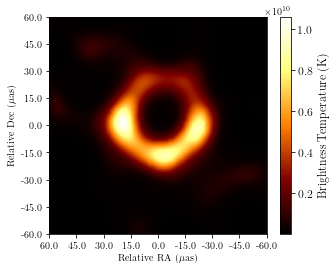

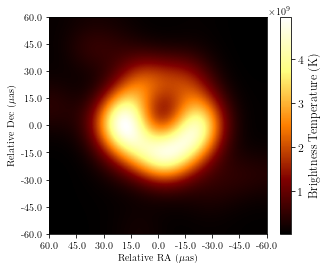

In [6]:
# display results
im_i_out.display(cbar_unit=['Tb'],has_title=False);
im_i_out.blur_circ(20*eh.RADPERUAS).display(cbar_unit=['Tb'],has_title=False);

## Polarimetric Imaging

In [7]:
# flag zero baselines
obs_pol_nodcal = obs_i_out.flag_uvdist(0.1e9)

# initial/prior images
init_im = im_i_out.add_const_pol(0,0)
prior_im = gaussprior.add_const_pol(0,0)

# imager
imgr = eh.imager.Imager(obs_pol_nodcal, init_im, prior_im, flux=zbl,
                        data_term=data_term_p, reg_term=reg_term_p,
                        maxit=maxit_p, 
                        epsilon_tv=epsilon_tv,norm_reg=True,
                        transform='mcv',pol='P')

# iterate imaging and D-term calibration
for repeat_pol in range(polcal_iter):
    # image
    for repeat in range(sub_polcal_iter):
        imgr.make_image_P(show_updates=False)
        imgr.init_next=imgr.out_last().blur_circ(0.,blurfrac*res)
        imgr.maxit_next=maxit_p + 50*repeat

    # D-term calibration
    obs_dcal = eh.leakage_cal(obs_pol_nodcal, imgr.out_last(),
                              sites=polcal_sites, leakage_tol=leakage_tol,
                              obs_apply=obs_pol_nodcal)
    imgr.obs_next=obs_dcal


U-V flagged 20/170 visibilities
No polarimetric image in init_next!
--initializing with 20% pol and random orientation!
Initializing imager data products . . .
Imager run 1 
Imaging Polarization: switching to Stokes!
No polarimetric image in init_next!
--initializing with 20% pol and random orientation!
Imaging . . .
time: 3.307816 s
J: -47.587514
chi2_m : 4.51 chi2_pvis : 4.69 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 2.156728 s
J: -47.833291
chi2_m : 4.37 chi2_pvis : 4.55 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 1.617560 s
J: -47.882625
chi2_m : 4.35 chi2_pvis : 4.53 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Finding leakage for sites: ['AZ', 'LM', 'PV']
Minimizing...
4.529110352391411 2.7557522346169794
Original chi-squared: 4.5291
New chi-squared: 2.7486

AZ
   D_R: 0.0182+0.0390j
   D_L: -0.0266+0.0574j

LM
   D_R: 0

time: 1.198323 s
J: -55.960839
chi2_m : 1.23 chi2_pvis : 1.33 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 23 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.102095 s
J: -55.961160
chi2_m : 1.23 chi2_pvis : 1.33 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 24 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.330029 s
J: -55.961160
chi2_m : 1.23 chi2_pvis : 1.33 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Finding leakage for sites: ['AZ', 'LM', 'PV']
Minimizing...
11.650440317117068 1.3386134728441526
Original chi-squared: 11.6504
New chi-squared: 1.3003

AZ
   D_R: 0.0374+0.0751j
   D_L: -0.0408+0.1018j

LM
   D_R: 0.0168+0.0302j
   D_L: -0.0078+0.0001j

PV
   D_R: -0.0855-0.0102j
   D_L: 0.1030-0.0040j


leakage_cal time: 4.454308 s
Imager run 25 
Imaging Polarization: switching to Stokes!
changed observation!
Recomputing imager data products . . .
Imaging . . .
time: 0.294611 s
J: -56.060280
chi2_m : 1.19 chi2_pvis 

Imager run 45 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.237859 s
J: -56.310542
chi2_m : 1.13 chi2_pvis : 1.23 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Finding leakage for sites: ['AZ', 'LM', 'PV']
Minimizing...
14.813783107044097 1.2757553698594433
Original chi-squared: 14.8138
New chi-squared: 1.2266

AZ
   D_R: 0.0375+0.0758j
   D_L: -0.0396+0.1018j

LM
   D_R: 0.0162+0.0304j
   D_L: -0.0060-0.0001j

PV
   D_R: -0.1088-0.0125j
   D_L: 0.1297-0.0051j


leakage_cal time: 4.678554 s
Imager run 46 
Imaging Polarization: switching to Stokes!
changed observation!
Recomputing imager data products . . .
Imaging . . .
time: 0.055378 s
J: -56.318048
chi2_m : 1.13 chi2_pvis : 1.23 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 47 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.045306 s
J: -56.318082
chi2_m : 1.13 chi2_pvis : 1.23 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 48 
Imaging Polarization: switching to Stoke

15.347597667026463 1.271875855645174
Original chi-squared: 15.3476
New chi-squared: 1.2209

AZ
   D_R: 0.0376+0.0756j
   D_L: -0.0395+0.1016j

LM
   D_R: 0.0162+0.0304j
   D_L: -0.0057+0.0001j

PV
   D_R: -0.1126-0.0131j
   D_L: 0.1335-0.0055j


leakage_cal time: 4.690251 s
Imager run 67 
Imaging Polarization: switching to Stokes!
changed observation!
Recomputing imager data products . . .
Imaging . . .
time: 0.329739 s
J: -56.332165
chi2_m : 1.12 chi2_pvis : 1.22 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 68 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.245639 s
J: -56.332165
chi2_m : 1.12 chi2_pvis : 1.22 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 69 
Imaging Polarization: switching to Stokes!
Imaging . . .
time: 0.388270 s
J: -56.332165
chi2_m : 1.12 chi2_pvis : 1.22 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Finding leakage for sites: ['AZ', 'LM', 'PV']
Minimizing...
15.34759766702678 1.271875855645181
Original chi-squared

In [8]:
# output image and observation
im_p_out = imgr.out_last()
obs_p_out = obs_dcal.copy()

# output array with determs
arr_p_out = eh.array.Array(obs_p_out.tarr)

# self-calibrate stokes I again after D-term cal
# TODO: always confused if this is the right order
caltable_p_out = eh.selfcal(obs_in, im_p_out, 
                            apply_dterms=True, #!
                            method='both', use_grad=True, 
                            solution_interval=0., caltable=True)

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Applying dterms in obs.tarr to clean visibilities before selfcal!
Applying Jones Matrices to data . . . 
Warning!: in add_jones_and_noise, some SEFDs are <= 0!
Resorting to data point sigmas, which may add too much systematic noise!
   Applying D Term mixing: dcal-->False
Not Using Multiprocessing
Scan 21/22 : [----------------------------  ]95%
self_cal time: 0.573035 s


array([<Axes: title={'center': 'Right D-terms'}, xlabel='Real', ylabel='Imaginary'>,
       <Axes: title={'center': 'Left D-terms'}, xlabel='Real', ylabel='Imaginary'>],
      dtype=object)

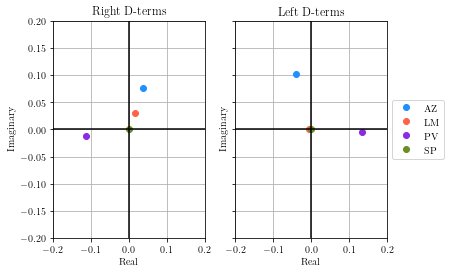

In [9]:
# plot dterms
# the dterm plotting function has a bug atm, this is a hack to plot only desired sites
arr_plot_dterm = arr_p_out.copy()
for site in arr_p_out.tarr['site']:
    if site not in polcal_sites:
        arr_plot_dterm = arr_plot_dterm.remove_site(site)
arr_plot_dterm.plot_dterms(rangex=[-.2,.2],rangey=[-.2,.2],sites=polcal_sites)

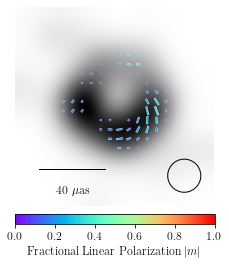

In [21]:
# display output image
im_p_out.blur_circ(20*eh.RADPERUAS).display(
                 plotp=True,pcut=0.2,mcut=0.07,
                 label_type='scale',scalecolor='k',
                 cfun='gray_r',cbar_unit=['Tb'],has_cbar=False,
                 vec_cfun='rainbow',nvec=18,vec_cbar_lims=(0,1),scale_ticks=True,
                 beamparams=[20*eh.RADPERUAS,20*eh.RADPERUAS,0],beamcolor='k',
                 has_title=False);

In [ ]:
# save ouptut
im_p_out.save_fits(outpath+'_output.fits')